<a href="https://colab.research.google.com/github/nisaac21/TradingAgentDQN/blob/main/Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import keras
from keras.models import Sequential 
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from tqdm import tqdm 
import io
import tensorflow as tf

##Problem 

The stock market is infamous for its complexity. In fact, the stock market is so nortiously difficult to profit from that 90-95% of retail and professional investors fails to outperform a market index. Most traders fail to make a consistent profit in the stock market due to the powerful emotions that arise when investing. In this notebook, we will provide an algorithmic approach to trading in the market in order to remove the emotional obstacle while still providing a consistent way to profit in the market

##Approach

Reinfrocement Learning has become very popular after seeing some of its more impressive applications (e.g. RL in GO). Today, we will implement a vanilla Deep Q network (DQN) to trade on historical AAPL stock data. 

The agent uses an actor to predict the value (summation of expected discounted rewards to termination) of taking a certain action in the given state. The actor will return a value for all possible actions in the action space, and the agent then makes an epsilon greedy (greedy decision, epsilon chance it takes a random decision) pased on the proposted state-action values. After an intialized amount of timesteps, the agent will then calculate the loss thorugh mean squared error of predictions against actual discounted rewards. If done (last state), the actual discounted reward is just the reward at the timestep otherwise the actual reward is assumed to be the current actual reward plus what the critic network predicts future value will be. The critic network is equivalent to the actor network, but does not have its weights change for an intialized increment of timesteps. 


States: The current day's closing stock bar data. The state is described by what price the stock opened, closed, highest price traded, and lowest price traded on this state. Agent also has access to the bar's date

Actions: The model can take three options buying the asset, selling the asset, or holding the current position. For simplicity, the agent must either be fully invested or fully in cash. The agent cannot short the asset. 

Reward: The amount of fluctuation in the held asset (not just on selling the asset). This encourages the agent to avoid holding through draw downs and focus on holding the asset for positive trends. 

In [76]:
class TradingAgent():

  def __init__(self, stock_data, 
    n=20, reset_increment=100, gamma = 0.99, 
      epsilon = 0.50, e_decay = 0.99, 
      filepath='', batch_size=1, loss='mean_squared_error', optimizer='sgd'):

    '''
    Intialize environment and training paraemters 
    
    Inputs
    ----------
    stock_data (Pandas DF) : representing all of the stock data to train and test on. Expected to have Price and % Change features at minimum
    n (int) : minimum amount of days to look back before calculating loss and updating training weights
    reset_increment (int) : how often (in timesteps) to set critic network to actor network weights
    gamma (int) : how important future rewards are (discount factor)
    epsilon (int) : percent of time to take a random action. Defaults to 0.50, lowest is 0.05
    e_decay (int) : What percent of the epsilon remains at each timestep, defaults to 0.99
    filepath (string) : Filepath of weights to load for actor LSTM model
    loss (string) : loss to use when updating weights, must be tf compatible. 
                    Defaults to mean_squared_error
    optimizer (string) : optimizer to use when updating weights, must be tf compatible. Defaults to stochaistic gradient descent
    '''
               
    '''Environment Information'''
    self.starting_capital = 1000
    self.stock_data = stock_data.iloc[::-1]
    self.stock_data.reset_index(drop=True, inplace=True)
    self.action_space = ['Buy', 'Sell', 'Hold']
    self.history = []

    '''Algorithm Hyper Parameters'''
    self.n = n 
    self.reset_increment = reset_increment
    self.gamma = gamma
    self.epsilon = epsilon
    self.e_decay = e_decay
    self.filepath = filepath
    self.batch_size = batch_size

    # Actor
    self.actor = self._build_actor() 
    self.actor.compile(optimizer, loss=loss)
    # Critic
    self.critic = keras.models.clone_and_build_model(self.actor)

  def _build_actor(self):
    '''
    Builds an actor model. If there is a relevant filepath for tf weights,
    will load those weights instead of a blank model. 

    Ouputs
    ----------
    model (Sequential) : LSTM RNN model that takes relevant features in and configures an output sized to action space
    '''
    
    model = Sequential()
    model.add(LSTM(units=96, return_sequences=True, 
                  input_shape=(len(self.stock_data.iloc[0]), 1)))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(units=256, activation="relu"))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=len(self.action_space)))
    if self.filepath != '':
      model.load_weights(self.filepath)

    return model

  def train(self, episodes):
    '''
    Begins the trading simulation using a Deep Q network strategy. 

    episodes (int) : number of simulation to run
    '''
    
    capital = []
    for _ in range(episodes):
      # Find index of start_data and begin collecting data from there
      # for each time step, get the necesary data and continue simulation 

      current_capital = self.starting_capital
      buy_and_hold = self.starting_capital
      have_position = True
      epsilon = self.epsilon

      for timestep in tqdm(range(len(self.stock_data) - 1)):
        
        capital.append(current_capital)

        state = self.stock_data.loc[timestep, :].to_list()
        state = np.array(state)
        state = np.reshape(state, (1,9))

        q_values = self.actor.predict(state, verbose=0)[0][0]

        # MAKE EPSILON GREEDY 
        action = self._epsilon_greedy(q_values, epsilon)

        done = timestep == len(self.stock_data) - 1

        action, have_position = self._action_position_correction(action, have_position)

        next_state = self.stock_data.loc[timestep+1, :]
        
        self._add_experience(state, action, next_state, done, current_capital, have_position)

        if action == 2 and have_position:
          current_capital = current_capital * (1 + next_state['Change %']) 

        buy_and_hold = buy_and_hold * (1 + next_state['Change %'] ) 
        
        if len(self.history) >= self.n:
          self._update(timestep) 
        
        epsilon = epsilon * self.e_decay \
        if epsilon * self.e_decay > 0.05 else 0.05

    capital.append(capital[len(capital)-1])
    action_list = [memory['action'] for memory in self.history]
    
    return capital, buy_and_hold, action_list

  def _epsilon_greedy(self, q_values, epsilon):
    '''
    Epsilon greedy policy agent follows in order to ensure baance betweem exploration and eploitation. 
    Makes a random action epsilon % of the time 

    Inputs
    ----------
    q_values(List-of ints) : Predicted state ation value for all potential actions from this state
    epsilon (float) : Decimal representation of percent of time to take random action

    Outputs
    ----------
    action (int) : index of action to take from self.action_space
    '''

    if random.random() < epsilon:  # with p = epsilon, we randomly sample an action
      return self.action_space.index(random.choice(self.action_space))
    else:  # With p = 1 - epsilon, derive a greedy policy from the Q table
      max_values = np.array([i for i, j in enumerate(q_values) if j == max(q_values)])
      return random.choice(max_values)

  def _add_experience(self, state, action, next_state, 
                      done, current_capital, have_position):
    '''
    Method for adding a market experience (memory) into this agent's history

    Inputs
    ----------
    state (pandas df) : array of features describing the state
    action (int) : action taken at state
    next_state (pandas df) : resulting state
    done (bool) : True if this is final state
    current_capital (float) : value of agent's portfolio at this state
    have_position (bool) : True if currently have a position in the equity
    '''
    reward = (next_state['Change %']) * current_capital \
    if have_position and action == 2 else 0

    self.history.append({
      'state' : state,
      'action' : self.action_space[action],
      'reward' : reward,
      'next_state' : next_state,
      'done' : done,
    }) 

  def _update(self, t):
    '''
    Updates stock actor with last self.n from tracked history 

    Inputs
    ---------
    t (int) : timestep we are on
    '''

    mini_batch = self._sample_batch()
    x = []
    y = []
    for memory in mini_batch:
      state = memory['state'][0]
      action = memory['action']
      reward = memory['reward']
      next_state = memory['next_state']
      done = memory['done']
      x.append(state)
      if done:
        y.append(reward)
      else:
        y.append(
            reward + self.gamma * max(self.critic.predict(next_state, verbose=0)[0]))

    self.actor.fit(np.array(x), np.array(y), verbose=0) # Handles loss and backprop

    if (t-self.n) % self.reset_increment == 0:
      self.critic.set_weights(self.actor.get_weights())

  def _sample_batch(self):
    '''
    Samples a mini batch to train on from experience 

    Returns
    ----------
    mini_batch (List-of memories) : List of randomly selected memories from agent's history
    '''

    indices = [np.random.randint(0, len(self.history)) for _ in range(self.batch_size)]
    return self._encode_batch(indices)

  def _encode_batch(self, indicies):
    '''
    Takes a list of history indicies and returns the corresponding data to that experience

    Inputs
    ----------
    indicies (List-of-ints) : list of size self.batch_size filled with random indicies for self.history

    Outputs
    ----------
    batch (List-of memories) : List of size self.batch_size filled with previous experiences (memories)
    '''

    batch = []
    for i in indicies:
      memory = {}
      memory['state'] = self.history[i]['state']
      memory['action'] = self.history[i]['action']
      memory['reward'] = self.history[i]['reward']
      memory['next_state'] = self.history[i]['next_state']
      memory['done'] = self.history[i]['done']
      batch.append(memory)

    return batch

  def _action_position_correction(self, action, have_position):
    '''
    Helper method for returning correct action and have_position truth based
    on current action decision and current have_position truth 

    Inputs
    ----------
    action (int) : index (from self.action_space) of action 
    have_position (bool) : True if agent has an active position

    Outputs
    ----------
    act (int) : corrected action index based on decision agent makes 
    position (bool) : corrected position truth based on action taken  
    '''
    position = have_position
    act = action

    # If agent tries to buy while it has a position
    if act == 0 and position:
      act = 2

    # If agent tries to sell while it does not have a position
    if act == 1 and not position:
      act = 2

    # If agent correctly buys a position 
    if act == 0:
      position = True

    # If agent correctly sells a position
    if act == 1:
      position = False

    return act, position




Now lets look at the data we will be utilizing. 

In [37]:
df = pd.read_csv('AAPL Historical Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol String,Change %,Vol
0,11/30/2022,140.99,141.22,142.34,140.59,27.61M,-0.0013,27610000
1,11/29/2022,141.17,144.07,144.70,140.37,83.46M,-0.0211,83460000
2,11/28/2022,144.22,145.07,146.61,143.39,68.68M,-0.0263,68680000
3,11/25/2022,148.11,148.37,148.85,147.13,35.17M,-0.0196,35170000
4,11/23/2022,151.07,149.66,151.78,149.36,58.30M,0.0059,58300000


In [38]:
# Separating out year month and date
df['Date'] = df['Date'].apply(pd.to_datetime)
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df_split = df.drop('Date', axis=1)
df_split.head()

,Price,Open,High,Low,Vol String,Change %,Vol,Year,Month,Day
0,140.99,141.22,142.34,140.59,27.61M,-0.0013,27610000,2022,11,30
1,141.17,144.07,144.70,140.37,83.46M,-0.0211,83460000,2022,11,29
2,144.22,145.07,146.61,143.39,68.68M,-0.0263,68680000,2022,11,28
3,148.11,148.37,148.85,147.13,35.17M,-0.0196,35170000,2022,11,25
4,151.07,149.66,151.78,149.36,58.30M,0.0059,58300000,2022,11,23


In [40]:
# Only using data till 2019
df_train = df_split.drop(df_split[df_split['Year'] > 2019
   ].index, inplace = False)
df_train.drop('Vol String', axis = 1, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train.head()

,Price,Open,High,Low,Change %,Vol,Year,Month,Day
0,73.41,72.48,73.42,72.38,0.0073,100990000,2019,12,31
1,72.88,72.36,73.17,71.31,0.0059,144240000,2019,12,30
2,72.45,72.78,73.49,72.03,-0.0004,146370000,2019,12,27
3,72.48,71.20,72.50,71.17,0.0198,93340000,2019,12,26
4,71.07,71.17,71.22,70.73,0.0010,48480000,2019,12,24


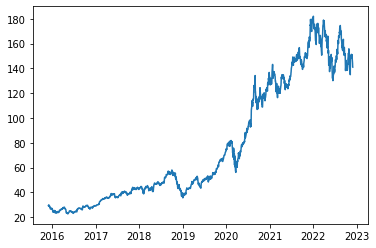

In [41]:
plt.plot(np.array(df['Date']), np.array(df['Price']))
plt.show()

##Results

Training the agent 

In [42]:
Agent = TradingAgent(df_train)
results, baseline, action_list= Agent.train(1)

100%|██████████| 1027/1027 [02:52<00:00,  5.95it/s]


In [78]:
results = results[::-1]

In [82]:
print("Below we see the results from using a buy and hold strategy")
print("or letting the agent trade on the asset starting with $1k")
print(f"Buy and hold: {baseline}")
print(f"Agent: {results[0]}")

Below we see the results from using a buy and hold strategy
or letting the agent trade on the asset starting with $1k
Buy and hold: 2500.4596257598714
Agent: 2179.883931511743


At first glance, we see some important underperformance. Now, let's see a plot of how the asset performed vs how the agent performed in the allotted time

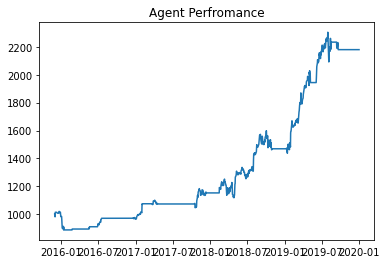

In [83]:
# Agent performance 
df_show = df
df_show.drop(df_show[df_show['Year'] > 2019
    ].index, inplace = True)
plt.plot(np.array(df_show['Date']), np.array(results))
plt.title("Agent Perfromance")
plt.show()

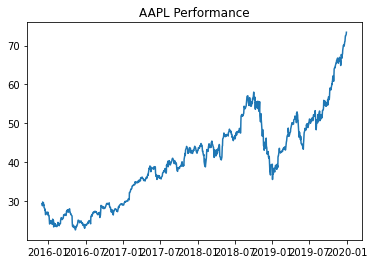

In [84]:
plt.plot(np.array(df_show['Date']), np.array(df_show['Price']))
plt.title("AAPL Performance")
plt.show()

While intially discouraging, we see some important features on this agent. While there was an underperformance, and the agent held through much of the rising 2017's, we see the agent clearly avoids drawdowns. In fact, the agent's performance is characterized by a 'stair stepping' higher of returns with minimal to no drawdowns. This is an important consideration for active investors as lower draw downs increases your sharpe ratio making your strategy look more attractive to outside captial. 

While a simplified example, this notebook shows some of the benefits of implementing algorithmic strategies into an investment philosophy. In future iterations of the model, the agent will begin to choose between stocks, have ability to allocate and short, and take into consideration frictions of real world trading. 

##Sources

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press

Koker, T. E, & Koutmos, D (2020). Cryptocurrency Trading Using Machine Learning. Multidisciplinary Digital Publishing Institute

Tam, A (2021). Using CNN for financial time series prediction. Machine Learning Mastery

Adusumilli, R (2019). Machine Learning to Predict Stock Prices. Towards Data Science